In [125]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import os
from parameters import parameters as pm
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import timeit
import joblib

import warnings
warnings.filterwarnings('ignore')

In [126]:
df_1=pd.read_excel('samples_para_stress_nogamma_0.1.xlsx')  
df_2=pd.read_excel('samples_para_stress_nogamma_0.2.xlsx')
df_3=pd.read_excel('samples_para_stress_nogamma_0.3.xlsx') 
df_4=pd.read_excel('samples_para_stress_nogamma_0.4.xlsx')  
df_5=pd.read_excel('samples_para_stress_nogamma.xlsx')     

df_total=[df_1,df_2,df_3,df_4,df_5]


In [127]:
for i in df_total:
    i.columns=['a','b','af','bf','as','bs','afs','bfs','sigma_fs_fs','sigma_sf_fs','sigma_fn_fn','sigma_nf_fn','sigma_ns_sn','sigma_sn_sn']


In [128]:
df_1.describe()

,a,b,af,bf,as,bs,afs,bfs,sigma_fs_fs,sigma_sf_fs,sigma_fn_fn,sigma_nf_fn,sigma_ns_sn,sigma_sn_sn
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,10.051099,10.050823,10.053594,10.041641,10.043808,10.040158,10.042038,10.048542,59.450273,59.460435,30.238469,29.238771,29.238771,30.248630
std,5.750127,5.750228,5.749374,5.744880,5.747095,5.741963,5.745040,5.749946,63.291248,63.342554,44.673169,44.709108,44.709108,44.696127
min,0.117477,0.113875,0.108680,0.104668,0.116491,0.117014,0.112519,0.112897,0.975872,0.730915,0.124415,0.027250,0.027250,0.239523
25%,5.082041,5.080430,5.072687,5.074195,5.073566,5.068185,5.079989,5.076965,14.195519,13.889141,3.848875,2.735975,2.735975,3.918491
50%,10.067975,10.059653,10.053391,10.032239,10.047240,10.030923,10.031350,10.043038,37.563899,37.739796,10.394284,9.255744,9.255744,10.233245
75%,15.025818,15.020589,15.028553,15.002848,15.000731,15.000922,15.003331,15.021940,82.061901,81.862505,35.631599,34.528103,34.528103,35.953738
max,19.999211,19.990205,19.993468,19.981656,19.981856,19.991570,19.999531,19.982412,381.083013,380.927118,274.475102,273.899506,273.899506,274.219865


In [129]:
feature_columns=['sigma_fs_fs','sigma_sf_fs','sigma_fn_fn','sigma_nf_fn','sigma_ns_sn','sigma_sn_sn']
parameters = ['a','b','af','bf','as','bs','afs','bfs']
for col in feature_columns:
    for i in df_total:
        i[col]=(i[col]-i[col].mean())/i[col].std()

In [130]:
q_1data=df_1.iloc[:,0:8]
q_2data=df_2.iloc[:,0:8]
q_3data=df_3.iloc[:,0:8]
q_4data=df_4.iloc[:,0:8]
q_5data=df_5.iloc[:,0:8]

In [158]:
y_1data=df_1.iloc[:,8:]
y_2data=df_2.iloc[:,8:]
y_3data=df_3.iloc[:,8:]
y_4data=df_4.iloc[:,8:]
y_5data=df_5.iloc[:,8:]




In [132]:
q_tot = [q_1data,q_2data,q_3data,q_4data,q_5data]
y_tot = [y_1data,y_2data,y_3data,y_4data,y_5data]

In [133]:
train_size=int(0.9*len(q_1data))

In [134]:
def train_qvalue(i):
    for i in q_tot:
        return (i.iloc[:train_size,:])
def test_qvalue(i):
    for i in q_tot:
        return (i.iloc[train_size:,:])


q_data_train=[]
q_data_test=[]
for i in q_tot:
    q_data_train.append(train_qvalue(q_tot))

for i in q_tot:
    q_data_test.append(test_qvalue(q_tot))

In [135]:
def train_yvalue(i):
    for i in y_tot:
        return (i.iloc[:train_size,:])
def test_yvalue(i):
    for i in y_tot:
        return (i.iloc[train_size:,:])

y_data_train=[]
y_data_test=[]

for i in y_tot:
    y_data_train.append(train_yvalue(y_tot))


for i in y_tot:
    y_data_test.append(test_yvalue(y_tot))

# from here q_idata_test = q_data_test[i-1]
#           y_idata_train/test = y_data_test[i-1]

In [136]:
class SklearnHelper(object):
    def __init__(self, clf, params=None,isMuilt_reg=False):
        if isMuilt_reg: self.clf= MultiOutputRegressor (clf(**params))
        else: self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def score(self,x,y):
        return self.clf.score(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [137]:
def mse_loss(y_true,y_pred):
    return np.mean(np.square(y_true-y_pred))


X_1 = q_data_train[0].values
y_1 = y_data_train[0].values
X_1test = q_data_test[0].values
y_1test=y_data_test[0].values


array([[-0.65691271, -0.67545186, -0.5451698 , -0.55349233, -0.55349233,
        -0.57191719],
       [-0.67418955, -0.65811313, -0.51039747, -0.49141588, -0.49141588,
        -0.48812599],
       [ 1.03126206,  0.99968961,  1.6925397 ,  1.66971181,  1.66971181,
         1.64811019],
       ...,
       [ 1.12022957,  1.10019184,  0.36759192,  0.36170475,  0.36170475,
         0.3402919 ],
       [ 0.00402225, -0.00615885,  0.60809884,  0.59635439,  0.59635439,
         0.59336262],
       [-0.75066732, -0.75358505, -0.48280162, -0.48709098, -0.48709098,
        -0.48755025]])

In [138]:
X_2 = q_data_train[1].values
y_2 = y_data_train[1].values
X_2test = q_data_test[1].values
y_2test=y_data_test[1].values


array([[-0.65691271, -0.67545186, -0.5451698 , -0.55349233, -0.55349233,
        -0.57191719],
       [-0.67418955, -0.65811313, -0.51039747, -0.49141588, -0.49141588,
        -0.48812599],
       [ 1.03126206,  0.99968961,  1.6925397 ,  1.66971181,  1.66971181,
         1.64811019],
       ...,
       [ 1.12022957,  1.10019184,  0.36759192,  0.36170475,  0.36170475,
         0.3402919 ],
       [ 0.00402225, -0.00615885,  0.60809884,  0.59635439,  0.59635439,
         0.59336262],
       [-0.75066732, -0.75358505, -0.48280162, -0.48709098, -0.48709098,
        -0.48755025]])

In [139]:
X_3 = q_data_train[2].values
y_3 = y_data_train[2].values
X_3test = q_data_test[2].values
y_3test=y_data_test[2].values

In [140]:
X_4 = q_data_train[3].values
y_4 = y_data_train[3].values
X_4test = q_data_test[3].values
y_4test=y_data_test[3].values

In [141]:
X_5 = q_data_train[4].values
y_5 = y_data_train[4].values
X_5test = q_data_test[4].values
y_5test=y_data_test[4].values

In [142]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern,RationalQuadratic

In [143]:
start = timeit.default_timer()
kernel = ConstantKernel(100, (1e-3, 1e3))*RBF(length_scale= 1.0, length_scale_bounds=(0.0,100))

gpr_1models=[]
for feat_flag in range(6):
    gpr_1sub = GaussianProcessRegressor(kernel=kernel,
                    random_state=0)
    print('fitting feature %d' % feat_flag)
    gpr_1sub.fit(X_1, y_1[:, feat_flag])
    print(gpr_1sub.kernel_)
    gpr_1models.append(gpr_1sub)
stop = timeit.default_timer()

print('Time: ', stop - start)

fitting feature 0
11.9**2 * RBF(length_scale=26.4)
fitting feature 1
11.9**2 * RBF(length_scale=26.4)
fitting feature 2
14.9**2 * RBF(length_scale=28.5)
fitting feature 3
14.9**2 * RBF(length_scale=28.5)
fitting feature 4
14.9**2 * RBF(length_scale=28.5)
fitting feature 5
14.9**2 * RBF(length_scale=28.5)
Time:  35.77702109999882


In [144]:
start = timeit.default_timer()
kernel = ConstantKernel(100, (1e-3, 1e3))*RBF(length_scale= 1.0, length_scale_bounds=(0.0,100))

gpr_2models=[]
for feat_flag in range(6):
    gpr_2sub = GaussianProcessRegressor(kernel=kernel,
                    random_state=0)
    print('fitting feature %d' % feat_flag)
    gpr_2sub.fit(X_2, y_2[:, feat_flag])
    print(gpr_2sub.kernel_)
    gpr_2models.append(gpr_2sub)
stop = timeit.default_timer()

print('Time: ', stop - start)

fitting feature 0
11.9**2 * RBF(length_scale=26.4)
fitting feature 1
11.9**2 * RBF(length_scale=26.4)
fitting feature 2
14.9**2 * RBF(length_scale=28.5)
fitting feature 3
14.9**2 * RBF(length_scale=28.5)
fitting feature 4
14.9**2 * RBF(length_scale=28.5)
fitting feature 5
14.9**2 * RBF(length_scale=28.5)
Time:  36.0886376999988


In [145]:
start = timeit.default_timer()
kernel = ConstantKernel(100, (1e-3, 1e3))*RBF(length_scale= 1.0, length_scale_bounds=(0.0,100))

gpr_3models=[]
for feat_flag in range(6):
    gpr_3sub = GaussianProcessRegressor(kernel=kernel,
                    random_state=0)
    print('fitting feature %d' % feat_flag)
    gpr_3sub.fit(X_1, y_1[:, feat_flag])
    print(gpr_3sub.kernel_)
    gpr_3models.append(gpr_3sub)
stop = timeit.default_timer()

print('Time: ', stop - start)

fitting feature 0
11.9**2 * RBF(length_scale=26.4)
fitting feature 1
11.9**2 * RBF(length_scale=26.4)
fitting feature 2
14.9**2 * RBF(length_scale=28.5)
fitting feature 3
14.9**2 * RBF(length_scale=28.5)
fitting feature 4
14.9**2 * RBF(length_scale=28.5)
fitting feature 5
14.9**2 * RBF(length_scale=28.5)
Time:  35.470121300000756


In [146]:
start = timeit.default_timer()
kernel = ConstantKernel(100, (1e-3, 1e3))*RBF(length_scale= 1.0, length_scale_bounds=(0.0,100))

gpr_4models=[]
for feat_flag in range(6):
    gpr_4sub = GaussianProcessRegressor(kernel=kernel,
                    random_state=0)
    print('fitting feature %d' % feat_flag)
    gpr_4sub.fit(X_4, y_4[:, feat_flag])
    print(gpr_4sub.kernel_)
    gpr_4models.append(gpr_4sub)
stop = timeit.default_timer()

print('Time: ', stop - start)

fitting feature 0
11.9**2 * RBF(length_scale=26.4)
fitting feature 1
11.9**2 * RBF(length_scale=26.4)
fitting feature 2
14.9**2 * RBF(length_scale=28.5)
fitting feature 3
14.9**2 * RBF(length_scale=28.5)
fitting feature 4
14.9**2 * RBF(length_scale=28.5)
fitting feature 5
14.9**2 * RBF(length_scale=28.5)
Time:  34.83526740000161


In [147]:
start = timeit.default_timer()
kernel = ConstantKernel(100, (1e-3, 1e3))*RBF(length_scale= 1.0, length_scale_bounds=(0.0,100))

gpr_5models=[]
for feat_flag in range(6):
    gpr_5sub = GaussianProcessRegressor(kernel=kernel,
                    random_state=0)
    print('fitting feature %d' % feat_flag)
    gpr_5sub.fit(X_5, y_5[:, feat_flag])
    print(gpr_5sub.kernel_)
    gpr_5models.append(gpr_5sub)
stop = timeit.default_timer()

print('Time: ', stop - start)

fitting feature 0
11.9**2 * RBF(length_scale=26.4)
fitting feature 1
11.9**2 * RBF(length_scale=26.4)
fitting feature 2
14.9**2 * RBF(length_scale=28.5)
fitting feature 3
14.9**2 * RBF(length_scale=28.5)
fitting feature 4
14.9**2 * RBF(length_scale=28.5)
fitting feature 5
14.9**2 * RBF(length_scale=28.5)
Time:  34.45144920000166


In [148]:
for feat_flag in range(6):
    print('fitting feature %d' % feat_flag)
    gpr_1sub = gpr_1models[feat_flag]
    pred = gpr_1sub.predict(X_1test)
    print('gpr Test: mse loss={:.6f} r2_score={:.6f}'.format(
        mse_loss(y_1test[:, feat_flag], pred),metrics.r2_score(y_1test[:, feat_flag], pred)))

fitting feature 0
gpr Test: mse loss=0.006126 r2_score=0.991505
fitting feature 1
gpr Test: mse loss=0.006118 r2_score=0.991488
fitting feature 2
gpr Test: mse loss=0.004523 r2_score=0.994570
fitting feature 3
gpr Test: mse loss=0.004516 r2_score=0.994581
fitting feature 4
gpr Test: mse loss=0.004516 r2_score=0.994581
fitting feature 5
gpr Test: mse loss=0.004516 r2_score=0.994574


In [149]:
for feat_flag in range(6):
    print('fitting feature %d' % feat_flag)
    gpr_2sub = gpr_2models[feat_flag]
    pred = gpr_2sub.predict(X_2test)
    print('gpr Test: mse loss={:.6f} r2_score={:.6f}'.format(
        mse_loss(y_2test[:, feat_flag], pred),metrics.r2_score(y_2test[:, feat_flag], pred)))

fitting feature 0
gpr Test: mse loss=0.006126 r2_score=0.991505
fitting feature 1
gpr Test: mse loss=0.006118 r2_score=0.991488
fitting feature 2
gpr Test: mse loss=0.004523 r2_score=0.994570
fitting feature 3
gpr Test: mse loss=0.004516 r2_score=0.994581
fitting feature 4
gpr Test: mse loss=0.004516 r2_score=0.994581
fitting feature 5
gpr Test: mse loss=0.004516 r2_score=0.994574


In [150]:
for feat_flag in range(6):
    print('fitting feature %d' % feat_flag)
    gpr_3sub = gpr_3models[feat_flag]
    pred = gpr_3sub.predict(X_3test)
    print('gpr Test: mse loss={:.6f} r2_score={:.6f}'.format(
        mse_loss(y_3test[:, feat_flag], pred),metrics.r2_score(y_3test[:, feat_flag], pred)))

fitting feature 0
gpr Test: mse loss=0.006126 r2_score=0.991505
fitting feature 1
gpr Test: mse loss=0.006118 r2_score=0.991488
fitting feature 2
gpr Test: mse loss=0.004523 r2_score=0.994570
fitting feature 3
gpr Test: mse loss=0.004516 r2_score=0.994581
fitting feature 4
gpr Test: mse loss=0.004516 r2_score=0.994581
fitting feature 5
gpr Test: mse loss=0.004516 r2_score=0.994574


In [151]:
for feat_flag in range(6):
    print('fitting feature %d' % feat_flag)
    gpr_4sub = gpr_4models[feat_flag]
    pred = gpr_4sub.predict(X_4test)
    print('gpr Test: mse loss={:.6f} r2_score={:.6f}'.format(
        mse_loss(y_4test[:, feat_flag], pred),metrics.r2_score(y_4test[:, feat_flag], pred)))

fitting feature 0
gpr Test: mse loss=0.006126 r2_score=0.991505
fitting feature 1
gpr Test: mse loss=0.006118 r2_score=0.991488
fitting feature 2
gpr Test: mse loss=0.004523 r2_score=0.994570
fitting feature 3
gpr Test: mse loss=0.004516 r2_score=0.994581
fitting feature 4
gpr Test: mse loss=0.004516 r2_score=0.994581
fitting feature 5
gpr Test: mse loss=0.004516 r2_score=0.994574


In [152]:
for feat_flag in range(6):
    print('fitting feature %d' % feat_flag)
    gpr_5sub = gpr_5models[feat_flag]
    pred = gpr_5sub.predict(X_5test)
    print('gpr Test: mse loss={:.6f} r2_score={:.6f}'.format(
        mse_loss(y_5test[:, feat_flag], pred),metrics.r2_score(y_5test[:, feat_flag], pred)))

fitting feature 0
gpr Test: mse loss=0.006126 r2_score=0.991505
fitting feature 1
gpr Test: mse loss=0.006118 r2_score=0.991488
fitting feature 2
gpr Test: mse loss=0.004523 r2_score=0.994570
fitting feature 3
gpr Test: mse loss=0.004516 r2_score=0.994581
fitting feature 4
gpr Test: mse loss=0.004516 r2_score=0.994581
fitting feature 5
gpr Test: mse loss=0.004516 r2_score=0.994574


In [153]:
from scipy import interpolate
from scipy.interpolate import interp1d

In [154]:
gamma_1=0.1
gamma_2=0.2
gamma_3=0.3
gamma_4=0.4
gamma_5=0.5


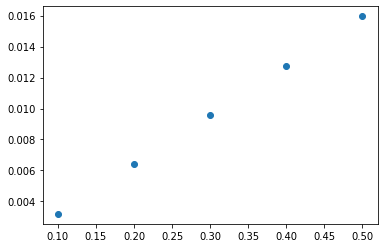

In [173]:
data = [
    [0.1, 0.2*np.mean(y_1)],
    [0.2, 0.4*np.mean(y_2)],
    [0.3, 0.6*np.mean(y_3)],
    [0.4, 0.8*np.mean(y_4)],
    [0.5, np.mean(y_5)],
    
]
x, y = zip(*data)
plt.scatter(x, y)
plt.show()

In [174]:
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

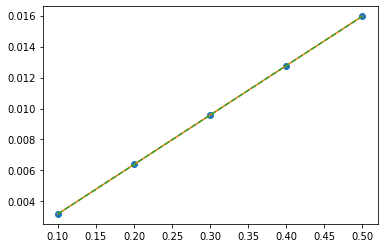

In [175]:
xnew = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')